In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
from geopy.distance import distance
from shapely.geometry import Point
from CoherentMovingCluster import CoherentMovingCluster
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [3]:
uji_data = pd.read_csv('Data\\AllData.csv')

## CMC using only data in building 2 floor 3 

The shapefile that defines the room geometries for building 2 floor 3 is used to determine the space ID for each coordinate. This is to demonstrate how CMC can be used in a real application.

In [4]:
b2f3 = uji_data[(uji_data['BUILDINGID'] == 2) & (uji_data['FLOOR'] == 3)]
b2f3 = uji_data[['TIMESTAMP', 'USERID', 'LONGITUDE', 'LATITUDE']]

In [5]:
room_gdf = gpd.read_file("Outputs\\2\\UJI_B2F3_rooms.shp")
cleaned_rooms = []
for room in room_gdf.geometry:
    room2 = room.buffer(0)
    cleaned_rooms.append(room2)
cleaned_rooms = gpd.GeoSeries(cleaned_rooms)

Define some hyperparameters and distance measure of data points for DBScan which is used in CMC.

In [6]:
dist_threshold = 2
min_pts = 2
min_lifetime = 5

In [7]:
TRANSFORMER = Transformer.from_crs("epsg:3857", "epsg:4326")

def row_geodesic_distance(row1, row2):
    row1_room = set(room_gdf[room_gdf.geometry.contains(Point(row1[2], row1[3]))].id.tolist())
    row2_room = set(room_gdf[room_gdf.geometry.contains(Point(row2[2], row2[3]))].id.tolist())

    if len(row1_room.intersection(row2_room)) == 0:
        # assume they are unreachable if coordinates are in different rooms
        return dist_threshold + 10
    
    x1, y1 = TRANSFORMER.transform(row1[3], row1[2])
    x2, y2 = TRANSFORMER.transform(row2[3], row2[2])
    
    return distance((x1, y1), (x2, y2)).meters

In [8]:
cmc = CoherentMovingCluster(min_pts, min_lifetime, dist_threshold, row_geodesic_distance)
convoys_list = cmc.offline_cmc(b2f3)
convoys = pd.DataFrame.from_records([c.to_dict() for c in convoys_list])

D:\USER\Anaconda\envs\geo_env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


#### Results 

In [9]:
convoys

,oids,rids,start_time,end_time
0,"[[12, 14], [12, 14], [12, 14]]","[[11785, 12527], [11827, 12223], [11874, 12223]]",1371716399,1371716413
1,"[[8, 9], [8, 9], [8, 9]]","[[4695, 6127], [4853, 5692], [5054, 6020]]",1371719834,1371719848
2,"[[5, 10], [5, 10], [5, 10]]","[[1740, 7055], [1868, 6234], [1929, 6234]]",1371719839,1371719853
3,"[[5, 10], [5, 10], [10, 5]]","[[2230, 6417], [1671, 6785], [6232, 1671]]",1371719864,1371719878
4,"[[5, 17], [5, 17], [5, 17], [5, 17], [5, 17], ...","[[1866, 17793], [1990, 17958], [2056, 18228], ...",1371719894,1371719928
...,...,...,...,...
80,"[[7, 11], [7, 11]]","[[3641, 7543], [4192, 7543]]",1371723374,1371723383
81,"[[11, 15], [11, 15]]","[[10231, 18118], [7544, 18118]]",1371723469,1371723478
82,"[[7, 15], [15, 7]]","[[3376, 17866], [17952, 3376]]",1371724629,1371724638
83,"[[7, 15], [15, 7]]","[[4624, 13830], [13854, 4624]]",1371724839,1371724848


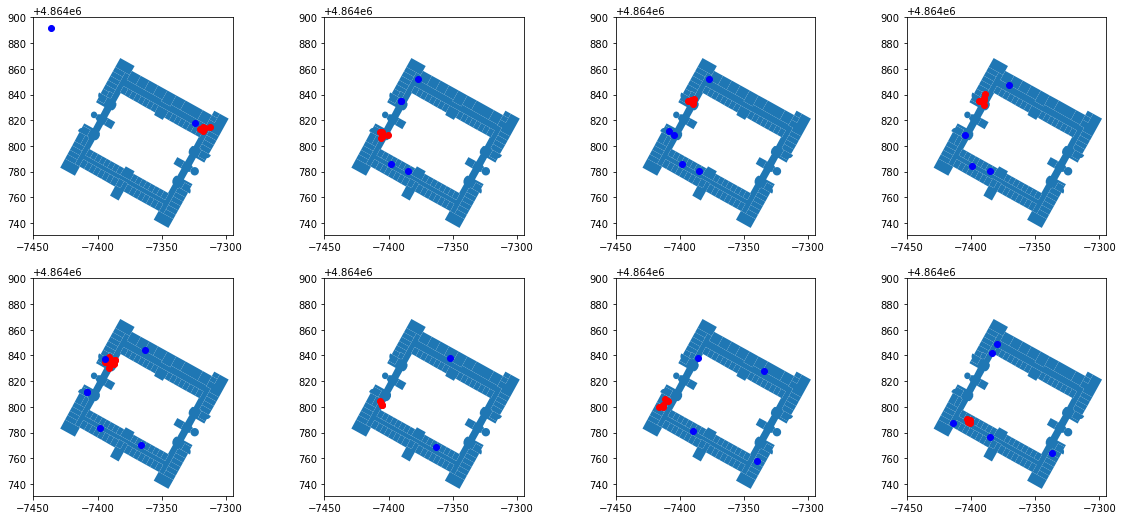

In [13]:
y_bottom, y_top = min(b2f3['LATITUDE']), max(b2f3['LATITUDE'])
x_left, x_right = min(b2f3['LONGITUDE']), max(b2f3['LONGITUDE'])
x_right += 5
y_bottom -= 15
x_left = -7450
y_top = 4864900

stdev = 0.01*max([y_top-y_bottom, x_right-x_left])
def rand_jitter(arr):
    return arr + np.random.randn(len(arr)) * stdev

plt.figure(figsize=(20,100))
size = 0
for i, convoy in convoys.iterrows():
    ax = plt.subplot(21, 4, i+1)

    all_locs = b2f3[(b2f3['TIMESTAMP'] > convoy.start_time) & (b2f3['TIMESTAMP'] <= convoy.end_time)]
    all_locs = all_locs.loc[all_locs.groupby('USERID').TIMESTAMP.idxmax()]
    
    all_rids = [i for snapshot in convoy.rids for i in snapshot]
    convoy_locs = b2f3.iloc[all_rids]
    non_convoy_locs = all_locs.loc[~all_locs.index.isin(all_rids)]
    
    cleaned_rooms.plot(ax=ax)
    ax.set_ylim(y_bottom, y_top)
    ax.set_xlim(x_left, x_right)
    ax.scatter(rand_jitter(convoy_locs['LONGITUDE']), rand_jitter(convoy_locs['LATITUDE']), color="r")
    ax.scatter(non_convoy_locs['LONGITUDE'], non_convoy_locs['LATITUDE'], color="b")
    size += 1
    if size == 8:
        break
    
plt.show()

#### Output to store

In [14]:
convoys.to_csv("Outputs\\3\\B2F3_convoys.csv")

## CMC using all data 

The pre-defined space ID, Building ID, and floor that comes with the dataset are used here to find all convoys in the entire dataset.

In [15]:
all_data = uji_data[['TIMESTAMP', 'USERID', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID']]

Define some hyperparameters and distance measure of data points for DBScan which is used in CMC.

In [16]:
dist_threshold = 2
min_pts = 2
min_lifetime = 5

def row_geodesic_distance(x, y):
    if x[4] != y[4] or x[5] != y[5] or x[6] != y[6]:
        # assume they are unreachable if they are in diff building, floor or room
        return dist_threshold + 10
    
    lat1, long1 = TRANSFORMER.transform(x[3], x[2]) # lat, long
    lat2, long2 = TRANSFORMER.transform(y[3], y[2])
    
    return distance((lat1, long1), (lat2, long2)).meters

In [17]:
cmc = CoherentMovingCluster(min_pts, min_lifetime, dist_threshold, row_geodesic_distance)
convoys_list = cmc.offline_cmc(all_data)
convoys_all = pd.DataFrame.from_records([c.to_dict() for c in convoys_list])

D:\USER\Anaconda\envs\geo_env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [18]:
convoys_all.to_csv("Outputs\\3\\all_convoys.csv")

## Network Analysis of Users in Close Contact

#### Generate adjacency matrix then network of users according to how close they are to each other

In [23]:
from itertools import combinations
users_count = uji_data['USERID'].unique().shape[0]
cmc_network = np.zeros(shape=(users_count, users_count))

for (_, data) in convoys_all.iterrows():
    all_oids = set([i for snapshot in data.oids for i in snapshot])
    for pair in list(combinations(all_oids, 2)):
        duration = sum([(pair[0] in snapshot and pair[1] in snapshot) for snapshot in data.oids]) * CoherentMovingCluster.TIME_INTERVAL
        cmc_network[pair[0], pair[1]] += data.end_time - data.start_time
        cmc_network[pair[1], pair[0]] += data.end_time - data.start_time
        
cmc_network = pd.DataFrame(cmc_network)
gr = nx.from_pandas_adjacency(cmc_network)

#### Network Analysis

In [24]:
for c in nx.connected_components(gr):
    print(c)

{0}
{1}
{2}
{3}
{4}
{11, 5, 14}
{6}
{15, 7}
{8, 9, 10, 17}
{12}
{13}
{16}
{18}


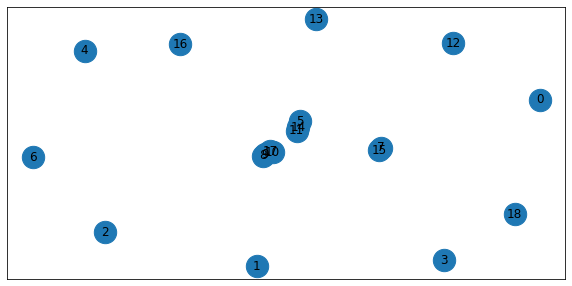

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(10,5))
scaled_weights = [gr[u][v]['weight']/100 for u, v in gr.edges()]
nx.draw_networkx(gr, node_size = 500, with_labels=True, width=scaled_weights)
plt.show()

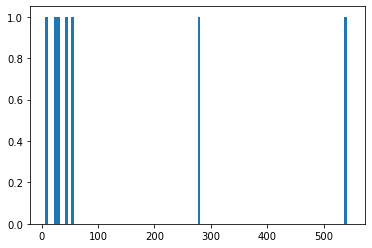

In [26]:
# distribution of weights
weights = [gr[u][v]['weight'] for u, v in gr.edges()]
weights = np.array(weights)
d = np.diff(np.unique(weights)).min()
left = weights.min() - float(d)/2
right = weights.max() + float(d)/2
plt.hist(weights, np.arange(left, right+d, d))
plt.show()

#### Save to output file

To be used in in "7 optimise_user_schedule"

In [27]:
np.savetxt('Outputs\\3\\cmc_adj_mat.csv', cmc_network, delimiter=',')